In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [2]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr_datasets import FederatedDataset

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.18.0 / PyTorch 2.6.0+cu124


In [4]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [5]:
from flwr_datasets.partitioner import DirichletPartitioner

# alpha=10 (iid), alpha=(0,1/0.3) noniid; alpha=0.01 (extreme noniid)
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.05,partition_by="label",seed=42)

In [6]:
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="mnist", partitioners={"train": partitioner}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

In [7]:
from collections import Counter

NUM_CLIENTS = 10
NUM_CLASSES = 10

total_counts_client_class = np.zeros((NUM_CLASSES, NUM_CLIENTS)) # (10*10)
for client_id in range(NUM_CLIENTS):
    trainloader, _, _ = load_datasets(client_id)
    label_list = []
    for batch in trainloader:
        labels = batch["label"] # 32 sized tensor and converting it into list by labels.tolist() & appending it to label_list
        label_list.extend(labels.tolist())
    class_counts = Counter(label_list)
    # Counter(label_list) is a dictionary to store one client has how many objects of 10 classes
    for cls in range(NUM_CLASSES):
        total_counts_client_class[cls][client_id] = class_counts.get(cls, 0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

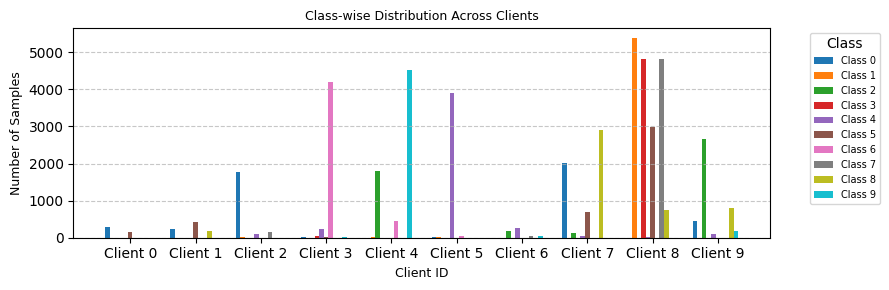

In [8]:
x=np.arange(NUM_CLIENTS)
bar_width=0.07

plt.figure(figsize=(9,3))

for cls in range(NUM_CLASSES):
    plt.bar(x+cls*bar_width,total_counts_client_class[cls],width=bar_width,label=f'Class {cls}')

plt.xlabel("Client ID", fontsize=9)
plt.ylabel("Number of Samples", fontsize=9)
plt.title("Class-wise Distribution Across Clients", fontsize=9)
plt.xticks(x+bar_width*NUM_CLASSES/2, [f"Client {i}" for i in range(NUM_CLIENTS)])
plt.legend(title="Class",bbox_to_anchor=(1.05,1),loc="upper left",fontsize=7)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()